In [1]:
import boa
import matplotlib.pyplot as plt

In [2]:
admin = boa.env.generate_address()
fee_receiver = boa.env.generate_address()
trader = boa.env.generate_address()
print(admin, fee_receiver, trader)

0xd13f0Bd22AFF8176761AEFBfC052a7490bDe268E 0xA73d7cddCf77c00827459f986bf828999B58C6Fe 0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B


In [3]:
pool_implementation = boa.load_partial("../../contracts/twocrypto-ng/main/CurveTwocryptoOptimized.vy")
gauge_implementation = boa.load_partial("../../contracts/twocrypto-ng/main/LiquidityGauge.vy")
math_implementation = boa.load("../../contracts/twocrypto-ng/main/CurveCryptoMathOptimized2.vy")
views_implementation = boa.load("../../contracts/twocrypto-ng/main/CurveCryptoViews2Optimized.vy")

with boa.env.prank(admin):
    factory = boa.load("../../contracts/twocrypto-ng/main/CurveTwocryptoFactory.vy")
    factory.initialise_ownership(fee_receiver, admin)

    factory.set_pool_implementation(pool_implementation.deploy_as_blueprint().address, 0)
    factory.set_gauge_implementation(gauge_implementation.deploy_as_blueprint().address)
    factory.set_math_implementation(math_implementation.address)
    factory.set_views_implementation(views_implementation.address)

print(
    "Factory: " + factory.address + "\n" +
    "Pool Implementation: " + factory.pool_implementations(0) + "\n" +
    "Gauge Implementation: " + factory.gauge_implementation() + "\n" +
    "Math Implementation: " + factory.math_implementation() + "\n" +
    "Views Implementation: " + factory.views_implementation()
    )

/Users/mo/Documents/CurveDocs/venv-notebook/lib/python3.11/site-packages/vyper/semantics/types/subscriptable.py:115: UserWarning: Use of large arrays can be unsafe!
  warnings.warn("Use of large arrays can be unsafe!")


Factory: 0xC6Acb7D16D51f72eAA659668F30A40d87E2E0551
Pool Implementation: 0x3d06E92f20305D9a2D71a1D479E9EE22690Ae7E4
Gauge Implementation: 0x78548820b365886d05009F1127bf553603E5A836
Math Implementation: 0x0880cf17Bd263d3d3a5c09D2D86cCecA3CcbD97c
Views Implementation: 0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9


In [4]:
# prepare pool params for deployment

A = 400000
gamma = 145000000000000
mid_fee = 26000000
out_fee = 45000000
allowed_extra_profit = 2000000000000
fee_gamma = 230000000000000
adjustment_step = 146000000000000
ma_time = 600
xcp_ma_time = 1800 * 24
initial_price = 10**18  # 1:1 at the start
admin_fee = 5 * 10**9

coin_a = boa.load("../../contracts/twocrypto-ng/mocks/ERC20Mock.vy", "coin_a", "coin_a", 18)
coin_b = boa.load("../../contracts/twocrypto-ng/mocks/ERC20Mock.vy", "coin_b", "coin_b", 18)

# deploying the pool

pool = factory.deploy_pool(
    "ng", "ng", [coin_a.address, coin_b.address],
    0, A, gamma, mid_fee, out_fee, fee_gamma, allowed_extra_profit, adjustment_step, int(ma_time/0.693), initial_price
)
pool = pool_implementation.at(pool)

/Users/mo/Documents/CurveDocs/venv-notebook/lib/python3.11/site-packages/vyper/ast/folding.py:153: UserWarning: ZERO_ADDRESS is deprecated. Please use `empty(address)` instead.
  warnings.warn(f"{name} is deprecated. Please use `{replacement}` instead.")


## **Ramping A and Gamma**

A and gamma values can only be ramped by the `admin` of the Factory.

Input values:
- **future_A:** future A value
- **future_gamma:** future gamma value
- **future_time:** time when ramping up/down finishes (minimum of 86400 (1d))

When ramping A/gamma, `future_A` and `future_gamma` values are packed and stored into a single uint256 variable (`future_A_gamma`).

In [5]:
# ts = current timestamp
ts = boa.env.vm.patch.timestamp


# unpack `future_A_gamma()`. These values are the current A/gamma values as we did not call `ramp_A_gamma` yet.
print("raw future_A_gamma: " + str(pool.future_A_gamma()))
print("A (unpacked): " + str(pool.future_A_gamma() >> 128))
print("gamma (unpacked): " + str(pool.future_A_gamma() & (2**128 -1)))
print("current timestamp: " + str(ts))
print("---------------")

# now we ramp up A and gamma and unpack `future_A_gamma()` again. as we can see, the values sucessfully changed. We can also query `future_A_gamma_time` to get the timestamp when ramping is finished.
with boa.env.prank(admin):
    pool.ramp_A_gamma(800000, 200000000000000, ts + 86400)

print("raw future_A_gamma: " + str(pool.future_A_gamma()))
print("A (unpacked): " + str(pool.future_A_gamma() >> 128))
print("gamma (unpacked): " + str(pool.future_A_gamma() & (2**128 -1)))
print("ramp finished: " + str(pool.future_A_gamma_time()))

A = []
gamma = []
timestamps = [] 

# increment timestamps by 2500 and save new A and gamma value in a dict
for current_time in range(ts, ts + 95000, 2500):
    A.append(pool.A())
    gamma.append(pool.gamma())
    timestamps.append(current_time)
    boa.env.time_travel(2500)

raw future_A_gamma: 136112946768375385385349842972852284582400000
A (unpacked): 400000
gamma (unpacked): 145000000000000
current timestamp: 1705405602
---------------
raw future_A_gamma: 272225893536750770770699685945614569164800000
A (unpacked): 800000
gamma (unpacked): 200000000000000
ramp finished: 1705492002


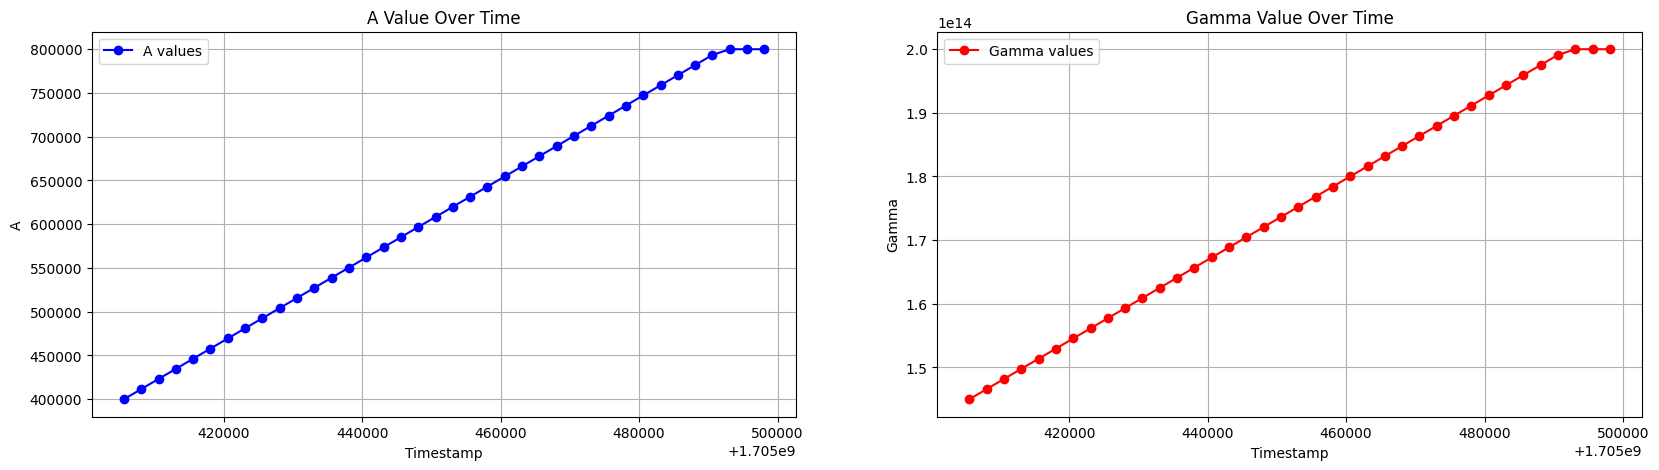

In [6]:
plt.figure(figsize=(20, 5))

# Subplot for A values
plt.subplot(1, 2, 1)
plt.plot(timestamps, A, label='A values', color='blue', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('A')
plt.title('A Value Over Time')
plt.legend()
plt.grid(True)

# Subplot for gamma values
plt.subplot(1, 2, 2)
plt.plot(timestamps, gamma, label='Gamma values', color='red', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Gamma')
plt.title('Gamma Value Over Time')
plt.legend()
plt.grid(True)

plt.show()


## Stop Ramping A and Gamma

The `admin` can stop the current ramping of the parameters via the `stop_ramp_A_gamma` function. To test this, lets ramp A and gamma again:

In [7]:
ts = boa.env.vm.patch.timestamp

print("before ramp: " + str(pool.A()))
print("before ramp: " + str(pool.gamma()))
print("----------")

# ramp A and gamma again
with boa.env.prank(admin):
    pool.ramp_A_gamma(1600000, 400000000000000, ts + 86400)

# now we time travel 40000 seconds (50% of the ramp time) and check the values to make sure its actually ramping up:
boa.env.time_travel(40000)
print("while ramp: " + str(pool.A()))
print("while ramp: " + str(pool.gamma()))
print("----------")

# stop the ramping
with boa.env.prank(admin):
    pool.stop_ramp_A_gamma()

# time travel again to check if the ramping has stopped
boa.env.time_travel(43200)
print("after stop: " + str(pool.A()))
print("after stop: " + str(pool.gamma()))

before ramp: 800000
before ramp: 200000000000000
----------
while ramp: 1170370
while ramp: 292592592592592
----------
after stop: 1170370
after stop: 292592592592592


## **Applying New Parameters**

New parameter can only be changed by the `admin` of the Factory.

Input values:
- **_new_mid_fee:** New mid fee value 
- **_new_out_fee:** New out fee value
- **_new_fee_gamma:** New fee gamma
- **_new_allowed_extra_profit:** New allowed extra profit value
- **_new_adjustment_step:** New adjustment step value
- **_new_ma_time:** New moving average time
- **_new_xcp_ma_time:** New xcp moving average time

In [8]:
print(
    "BEFORE APPLYING NEW PARAMETERS" + "\n" +
    "mid_fee: " + str(pool.mid_fee()) + "\n" +
    "out_fee: " + str(pool.out_fee()) + "\n" +
    "fee_gamma: " + str(pool.fee_gamma()) + "\n" +
    "allowed_extra_profit: " + str(pool.allowed_extra_profit()) + "\n" +
    "adjustment_step: " + str(pool.adjustment_step()) + "\n" +
    "ma_time: " + str(pool.ma_time()) + "\n" +
    "xcp_ma_time: " + str(pool.xcp_ma_time())
)

print("------------------------")

with boa.env.prank(admin):
    pool.apply_new_parameters(
        30000000, # _new_mid_fee
        45000000, # _new_out_fee
        300000000000000, # _new_fee_gamma
        3000000000000, # _new_allowed_extra_profit
        170000000000000, # _new_adjustment_step
        865, # _new_ma_time
        1800 * 24, # _new_xcp_ma_time
    )

print(
    "AFTER APPLYING NEW PARAMETERS:" + "\n" +
    "mid_fee: " + str(pool.mid_fee()) + "\n" +
    "out_fee: " + str(pool.out_fee()) + "\n" +
    "fee_gamma: " + str(pool.fee_gamma()) + "\n" +
    "allowed_extra_profit: " + str(pool.allowed_extra_profit()) + "\n" +
    "adjustment_step: " + str(pool.adjustment_step()) + "\n" +
    "ma_time: " + str(pool.ma_time()) + "\n" +
    "xcp_ma_time: " + str(pool.xcp_ma_time()),
)

BEFORE APPLYING NEW PARAMETERS
mid_fee: 26000000
out_fee: 45000000
fee_gamma: 230000000000000
allowed_extra_profit: 2000000000000
adjustment_step: 146000000000000
ma_time: 600
xcp_ma_time: 62324
------------------------
AFTER APPLYING NEW PARAMETERS:
mid_fee: 30000000
out_fee: 45000000
fee_gamma: 300000000000000
allowed_extra_profit: 3000000000000
adjustment_step: 170000000000000
ma_time: 600
xcp_ma_time: 43200
